In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from bs4 import BeautifulSoup as bsp
from collections import Counter
import re

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
import nltk as nlp
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("valid.csv")

train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [3]:
print(f'Train dataset consists of {train.shape[0]} rows, and {train.shape[1]} columns')

Train dataset consists of 45000 rows, and 6 columns


In [4]:
print(f'Test dataset consists of {test.shape[0]} rows, and {test.shape[1]} columns')

Test dataset consists of 15000 rows, and 6 columns


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            45000 non-null  int64 
 1   Title         45000 non-null  object
 2   Body          45000 non-null  object
 3   Tags          45000 non-null  object
 4   CreationDate  45000 non-null  object
 5   Y             45000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [6]:
train['Y'].value_counts()

Y
LQ_CLOSE    15000
HQ          15000
LQ_EDIT     15000
Name: count, dtype: int64

In [7]:
train['Y'].value_counts(normalize = True)

Y
LQ_CLOSE    0.333333
HQ          0.333333
LQ_EDIT     0.333333
Name: proportion, dtype: float64

In [8]:
test['Y'].value_counts()

Y
LQ_EDIT     5000
HQ          5000
LQ_CLOSE    5000
Name: count, dtype: int64

In [9]:
test['Y'].value_counts(normalize = True)

Y
LQ_EDIT     0.333333
HQ          0.333333
LQ_CLOSE    0.333333
Name: proportion, dtype: float64

In [10]:
train.isna().sum()

Id              0
Title           0
Body            0
Tags            0
CreationDate    0
Y               0
dtype: int64

In [11]:
train.duplicated().value_counts()

False    45000
Name: count, dtype: int64

In [12]:
test.duplicated().value_counts()

False    15000
Name: count, dtype: int64

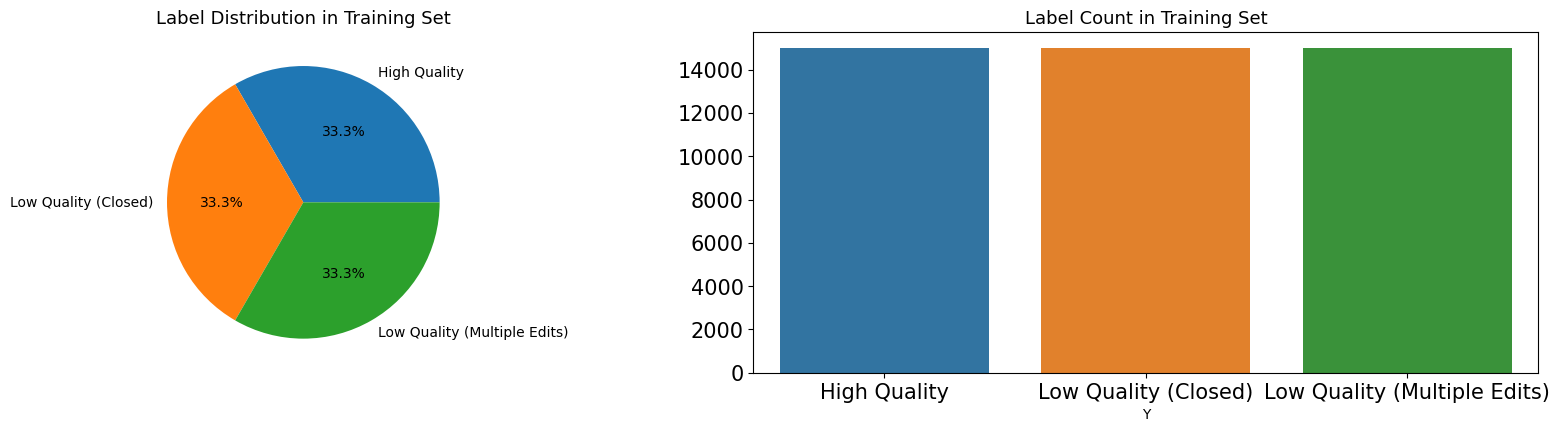

In [13]:
fig, axes = plt.subplots(ncols = 2, figsize = (17, 4), dpi = 100)
plt.tight_layout()

train.groupby('Y').count()['Id'].plot(kind = 'pie',autopct="%1.1f%%", ax = axes[0], labels = ['High Quality', 'Low Quality (Closed)', 'Low Quality (Multiple Edits)'])
sns.countplot(x = train['Y'], hue = train['Y'], ax = axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['High Quality', 'Low Quality (Closed)', 'Low Quality (Multiple Edits)'])
axes[0].tick_params(axis = 'x', labelsize = 15)
axes[0].tick_params(axis = 'y', labelsize = 15)
axes[1].tick_params(axis = 'x', labelsize = 15)
axes[1].tick_params(axis = 'y', labelsize = 15)

axes[0].set_title('Label Distribution in Training Set', fontsize = 13)
axes[1].set_title('Label Count in Training Set', fontsize = 13)

plt.show()

In [14]:
def get_hour(ts):
    return ts.hour
def get_day(ts):
    return ts.weekday()
def get_month(ts):
    return ts.month
def get_year(ts):
    return ts.year

In [15]:
train['CreationDate'] = pd.to_datetime(train['CreationDate'])

train['Creation_Hour'] = train['CreationDate'].apply(get_hour)
train['Creation_Weekday'] = train['CreationDate'].apply(get_day)
train['Creation_Month'] = train['CreationDate'].apply(get_month)
train['Creation_Year'] = train['CreationDate'].apply(get_year)

train.drop(columns=['CreationDate'],inplace=True)

In [16]:
test['CreationDate'] = pd.to_datetime(test['CreationDate'])

test['Creation_Hour'] = test['CreationDate'].apply(get_hour)
test['Creation_Weekday'] = test['CreationDate'].apply(get_day)
test['Creation_Month'] = test['CreationDate'].apply(get_month)
test['Creation_Year'] = test['CreationDate'].apply(get_year)

test.drop(columns=['CreationDate'],inplace=True)

In [17]:
train['Creation_Hour'].value_counts(normalize = True)

Creation_Hour
13    0.057356
14    0.056044
15    0.055289
11    0.055156
12    0.055111
9     0.054933
10    0.054711
16    0.051667
17    0.049133
18    0.048489
8     0.046244
19    0.046222
7     0.045444
20    0.042867
21    0.038489
6     0.038356
22    0.033000
5     0.030733
23    0.027044
4     0.026022
3     0.023067
2     0.022867
0     0.021422
1     0.020333
Name: proportion, dtype: float64

In [18]:
train['Creation_Weekday'].value_counts(normalize = True)

Creation_Weekday
2    0.167356
1    0.165378
3    0.163444
0    0.154333
4    0.153844
5    0.099400
6    0.096244
Name: proportion, dtype: float64

In [19]:
train['Creation_Month'].value_counts(normalize = True)

Creation_Month
1     0.107511
2     0.104933
3     0.100356
5     0.086000
9     0.083400
8     0.080489
4     0.080467
6     0.079467
7     0.076956
10    0.073600
12    0.065044
11    0.061778
Name: proportion, dtype: float64

In [20]:
train['Creation_Year'].value_counts(normalize = True)

Creation_Year
2016    0.338689
2017    0.268956
2018    0.229911
2019    0.143511
2020    0.018933
Name: proportion, dtype: float64

In [21]:
# Ensure stopwords are available; if not, fall back to a small built-in set
try:
    eng_sw = set(nlp.corpus.stopwords.words('english'))
except Exception:
    eng_sw = {'the','a','an','in','on','and','is','it','to','of'}
 
def get_char_amount(val):
    # Safely return length of text; handle NaN/None
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return 0
    try:
        return len(str(val))
    except Exception:
        return 0

def average_word_length(val):
    # Compute average word length excluding stopwords; return 0 for empty inputs
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return 0.0
    text = str(val).strip()
    if not text:
        return 0.0
    splited = text.split()
    char_count = 0
    word_count = 0
    for word in splited:
        w = word.strip()
        if not w:
            continue
        if w.lower() not in eng_sw:
            char_count += len(w)
            word_count += 1
    if word_count == 0:
        return 0.0
    return char_count / word_count

def number_of_words(val):
    # Count words excluding stopwords; return 0 for empty inputs
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return 0
    text = str(val).strip()
    if not text:
        return 0
    splited = text.split()
    word_count = 0
    for word in splited:
        w = word.strip()
        if not w:
            continue
        if w.lower() not in eng_sw:
            word_count += 1
    return word_count    

In [22]:
train['Body_Char_Length'] = train['Body'].apply(get_char_amount)
train['Title_Char_Length'] = train['Title'].apply(get_char_amount)
train['Body_Avg_Word_Length'] = train['Body'].apply(average_word_length)
train['Title_Avg_Word_Length'] = train['Title'].apply(average_word_length)
train['Body_Num_Of_Words'] = train['Body'].apply(number_of_words)
train['Title_Num_Of_Words'] = train['Title'].apply(number_of_words)

In [23]:
test['Body_Char_Length'] = test['Body'].apply(get_char_amount)
test['Title_Char_Length'] = test['Title'].apply(get_char_amount)
test['Body_Avg_Word_Length'] = test['Body'].apply(average_word_length)
test['Title_Avg_Word_Length'] = test['Title'].apply(average_word_length)
test['Body_Num_Of_Words'] = test['Body'].apply(number_of_words)
test['Title_Num_Of_Words'] = test['Title'].apply(number_of_words)

In [24]:
def tag_cleaner(val):
    splited = val.split('><')
    clean = []
    for tag in splited:
        tag =  tag.replace('<',' ')
        tag =  tag.replace('>',' ')
        clean.append(tag)
    return set(clean)

In [25]:
num_of_tags = []

for tag in train['Tags']:
    clean_tag = list(tag_cleaner(tag))
    num_of_tags.append(len(clean_tag))
train['Number_Of_Tags'] = num_of_tags

In [26]:
num_of_tags = []

for tag in test['Tags']:
    clean_tag = list(tag_cleaner(tag))
    num_of_tags.append(len(clean_tag))
test['Number_Of_Tags'] = num_of_tags

In [27]:
test['Number_Of_Tags'].value_counts()

Number_Of_Tags
2    4555
3    3988
1    2637
4    2356
5    1464
Name: count, dtype: int64

In [28]:
train['Number_Of_Tags'].value_counts()

Number_Of_Tags
2    13759
3    11940
1     8410
4     6779
5     4111
6        1
Name: count, dtype: int64

In [29]:
train['Tags'][train['Number_Of_Tags']==6]

36481    <javascript><php><html><html-email><forms><htt...
Name: Tags, dtype: object

In [30]:
train.drop(train.loc[train['Number_Of_Tags']==6].index, inplace=True)

In [31]:
train['Number_Of_Tags'].value_counts()

Number_Of_Tags
2    13759
3    11940
1     8410
4     6779
5     4111
Name: count, dtype: int64

In [32]:
train.describe()

,Id,Creation_Hour,Creation_Weekday,Creation_Month,Creation_Year,Body_Char_Length,Title_Char_Length,Body_Avg_Word_Length,Title_Avg_Word_Length,Body_Num_Of_Words,Title_Num_Of_Words,Number_Of_Tags
count,4.499900e+04,44999.000000,44999.000000,44999.000000,44999.000000,44999.000000,44999.000000,44999.000000,44999.000000,44999.000000,44999.000000,44999.000000
mean,4.575599e+07,12.407009,2.680260,5.976288,2017.235027,989.025156,53.778906,7.159008,5.836095,96.942243,7.521434,2.653815
std,7.120030e+06,6.000883,1.879744,3.448238,1.121535,1533.397661,22.155916,5.450588,1.763109,116.225093,3.233161,1.203994
min,3.455266e+07,0.000000,0.000000,1.000000,2016.000000,33.000000,15.000000,1.391716,1.833333,1.000000,1.000000,1.000000
25%,3.973586e+07,8.000000,1.000000,3.000000,2016.000000,328.000000,38.000000,5.433333,4.857143,40.000000,5.000000,2.000000
50%,4.503522e+07,13.000000,3.000000,6.000000,2017.000000,586.000000,50.000000,6.500000,5.571429,67.000000,7.000000,3.000000
75%,5.125457e+07,17.000000,4.000000,9.000000,2018.000000,1084.000000,65.000000,8.016828,6.428571,113.000000,9.000000,3.000000
max,6.046802e+07,23.000000,6.000000,12.000000,2020.000000,36718.000000,150.000000,673.500000,122.000000,5391.000000,31.000000,5.000000


In [33]:
def code_available(content):
    
    if('<code>' in content):
        return 1
    
    return 0

In [34]:
train['Code_Available'] = train['Body'].apply(code_available)

In [35]:
test['Code_Available'] = test['Body'].apply(code_available)

In [36]:
test

,Id,Title,Body,Tags,Y,Creation_Hour,Creation_Weekday,Creation_Month,Creation_Year,Body_Char_Length,Title_Char_Length,Body_Avg_Word_Length,Title_Avg_Word_Length,Body_Num_Of_Words,Title_Num_Of_Words,Number_Of_Tags,Code_Available
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,LQ_EDIT,1,4,1,2016,598,93,4.381443,4.785714,97,14,2,0
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,LQ_EDIT,8,4,1,2016,204,50,10.187500,5.285714,16,7,5,0
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,HQ,9,4,1,2016,1056,17,7.872549,8.000000,102,2,2,1
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,LQ_EDIT,10,4,1,2016,1497,24,6.613445,5.250000,119,4,2,0
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,LQ_EDIT,11,4,1,2016,1783,47,4.996016,6.500000,251,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,60465681,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,LQ_CLOSE,13,5,2,2020,847,52,11.242424,4.000000,66,10,3,1
14996,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,LQ_CLOSE,17,5,2,2020,997,55,6.955357,5.666667,112,6,1,1
14997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,LQ_EDIT,18,5,2,2020,1498,78,8.760684,4.214286,117,14,3,0
14998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,LQ_CLOSE,20,5,2,2020,759,37,7.183908,4.166667,87,6,3,1


In [37]:
train

,Id,Title,Body,Tags,Y,Creation_Hour,Creation_Weekday,Creation_Month,Creation_Year,Body_Char_Length,Title_Char_Length,Body_Avg_Word_Length,Title_Avg_Word_Length,Body_Num_Of_Words,Title_Num_Of_Words,Number_Of_Tags,Code_Available
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE,0,4,1,2016,313,38,5.386364,5.500000,44,6,2,0
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ,2,4,1,2016,113,33,6.142857,5.800000,14,5,2,0
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ,2,4,1,2016,4814,53,9.064690,5.750000,371,8,5,1
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ,3,4,1,2016,674,42,5.557895,5.166667,95,6,5,1
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ,5,4,1,2016,384,34,12.851852,6.000000,27,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,LQ_CLOSE,2,5,2,2020,884,58,9.717949,4.600000,78,10,3,1
44996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,LQ_CLOSE,3,5,2,2020,188,61,4.740741,4.666667,27,9,1,0
44997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,LQ_CLOSE,4,5,2,2020,145,36,4.500000,5.200000,24,5,2,0
44998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,LQ_CLOSE,12,5,2,2020,338,43,5.880952,5.200000,42,5,2,0


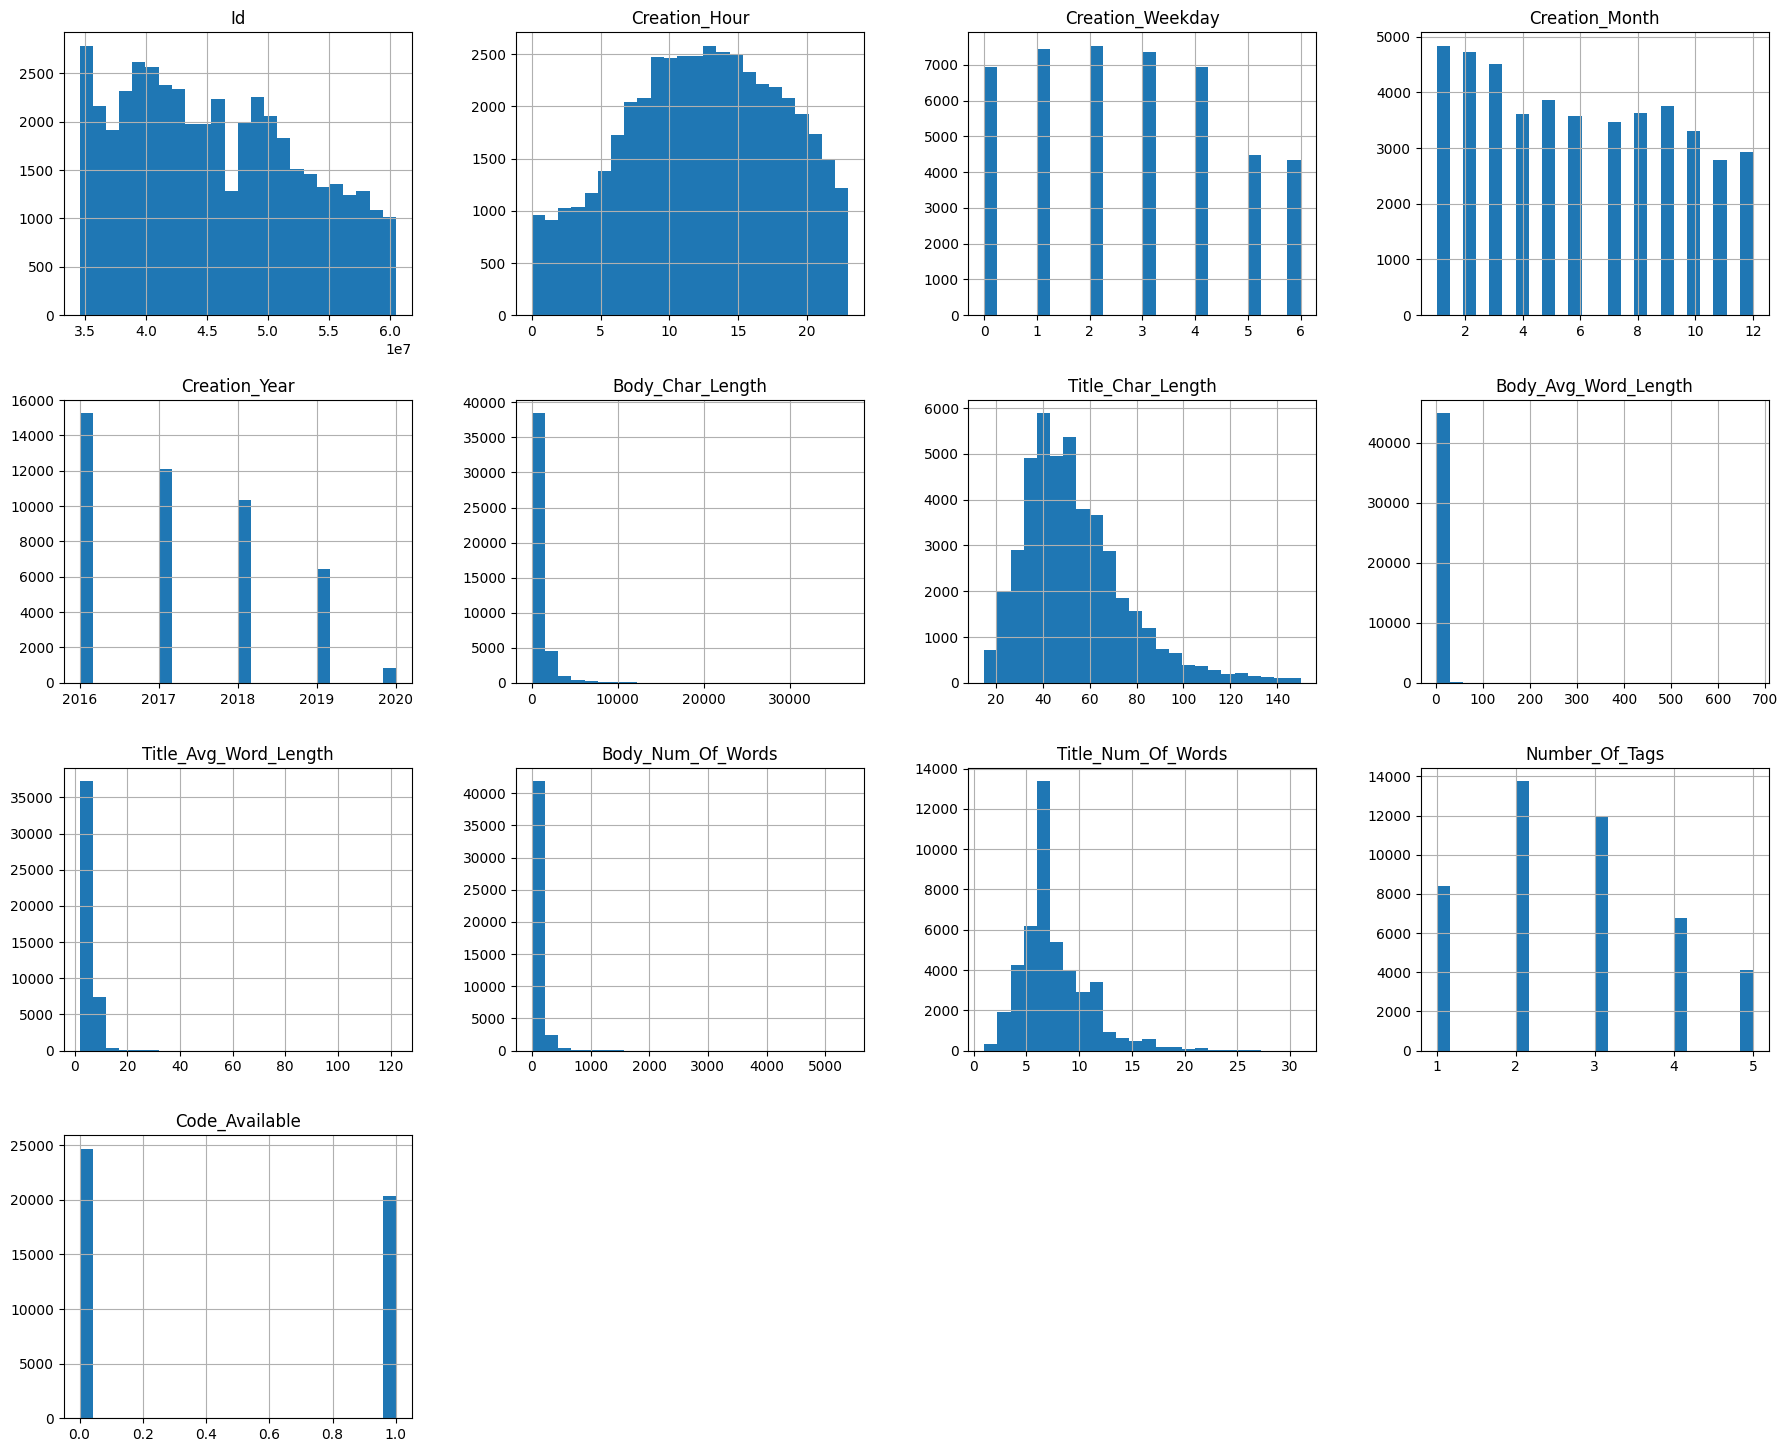

In [38]:
train.hist(bins=24, figsize=(22, 18))
plt.show()

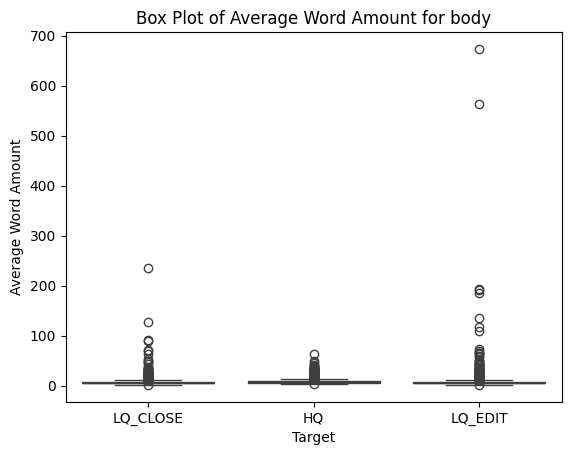

In [39]:
sns.boxplot(x='Y', y='Body_Avg_Word_Length', data=train)
plt.xlabel('Target')
plt.ylabel('Average Word Amount')
plt.title('Box Plot of Average Word Amount for body')
plt.show()

In [40]:
train['Body_Avg_Word_Length'][train['Body_Avg_Word_Length']> 500]

12503    673.5
26062    563.0
Name: Body_Avg_Word_Length, dtype: float64

In [41]:
train.drop(train.loc[train['Body_Avg_Word_Length']> 500].index, inplace=True)

(-1.0, 20.0)

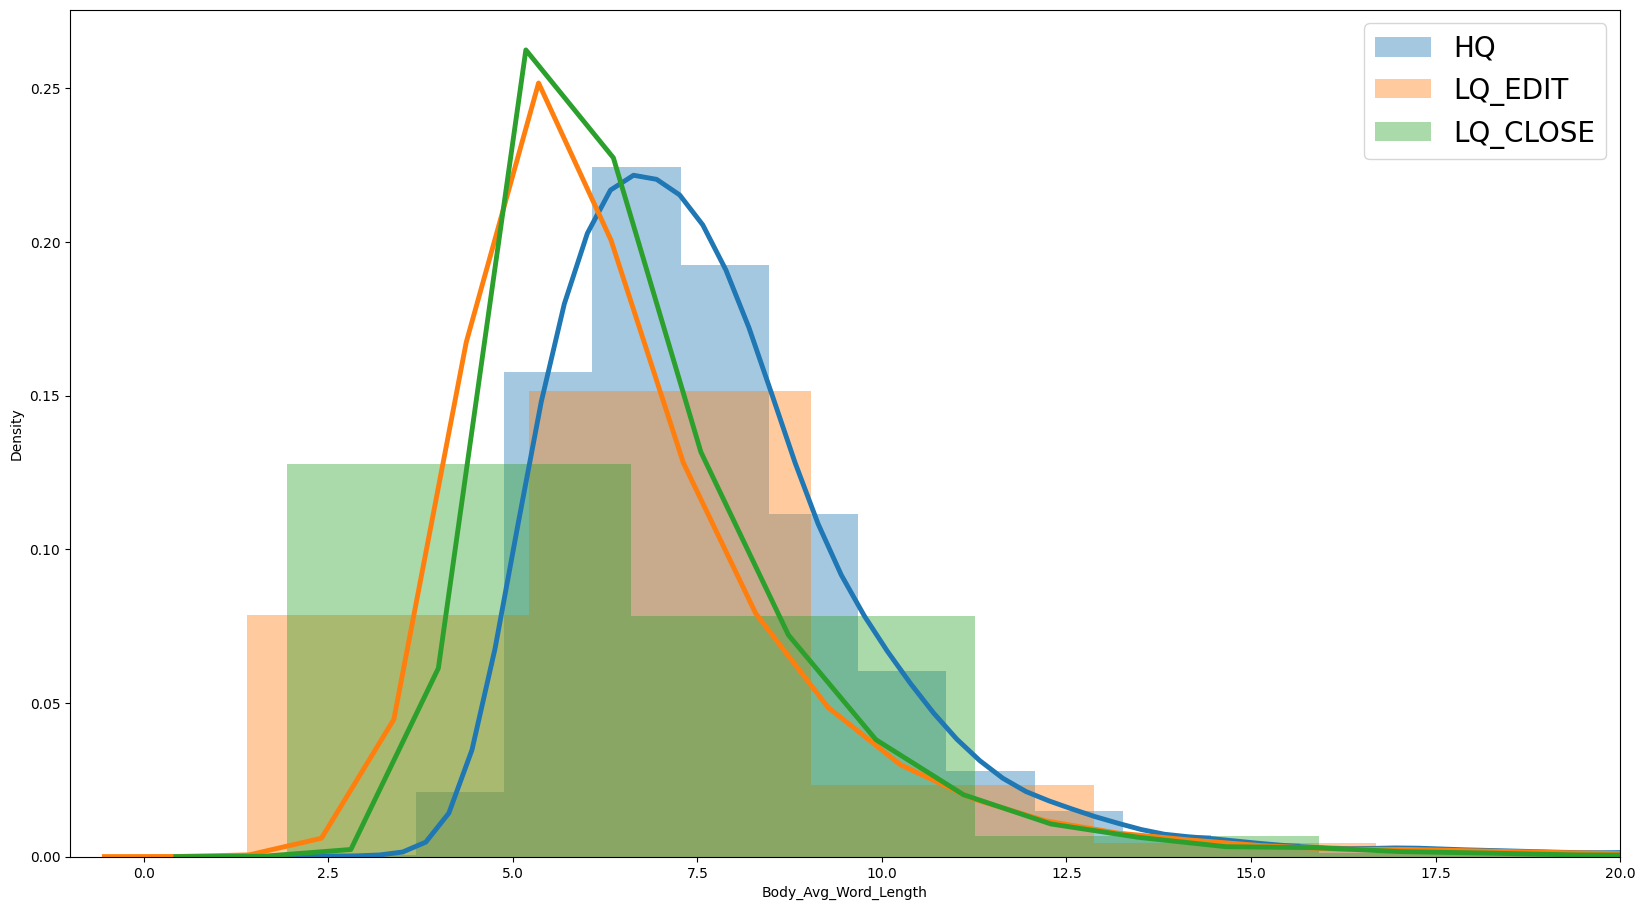

In [42]:
plt.figure(figsize=(20,11))

ax = sns.distplot(train[train['Y'] == 'HQ']['Body_Avg_Word_Length'],hist=True,kde_kws={'lw':3.5},label='HQ')
ax = sns.distplot(train[train['Y'] == 'LQ_EDIT']['Body_Avg_Word_Length'],hist=True,kde_kws={'lw':3.5},label='LQ_EDIT')
ax = sns.distplot(train[train['Y'] == 'LQ_CLOSE']['Body_Avg_Word_Length'],hist=True,kde_kws={'lw':3.5},label='LQ_CLOSE')
ax.legend(prop={'size':20})
plt.xlim(-1,20)

Text(0.5, 0, 'Body and Title average word length')

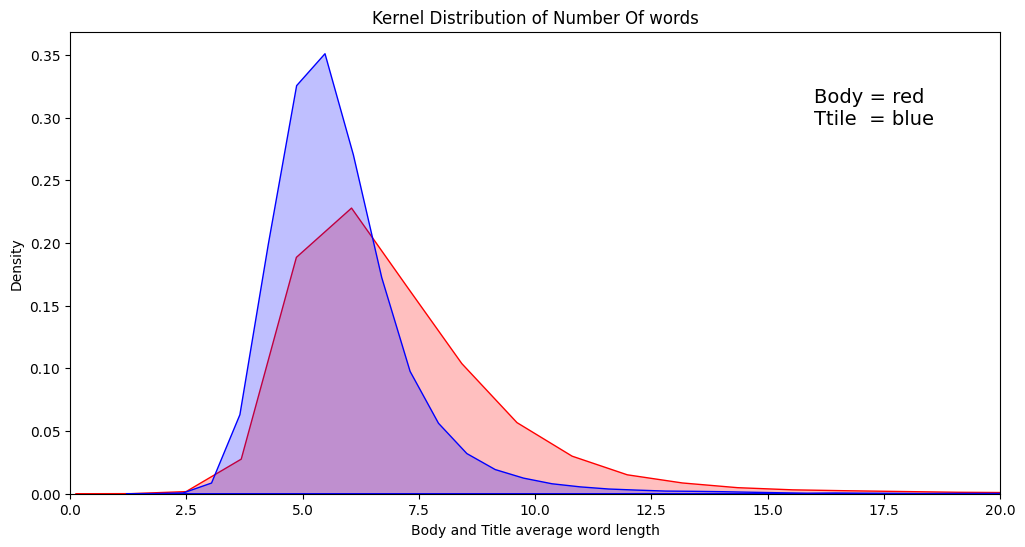

In [43]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Body_Avg_Word_Length'], shade=True, color="r", label='Body').set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Title_Avg_Word_Length'], shade=True, color="b", label='Title')
plt.xlim(0,20)
plt.text(x=0.8, y=0.8, s="Body = red\nTtile  = blue", fontsize=14, transform=plt.gca().transAxes)
plt.xlabel('Body and Title average word length')

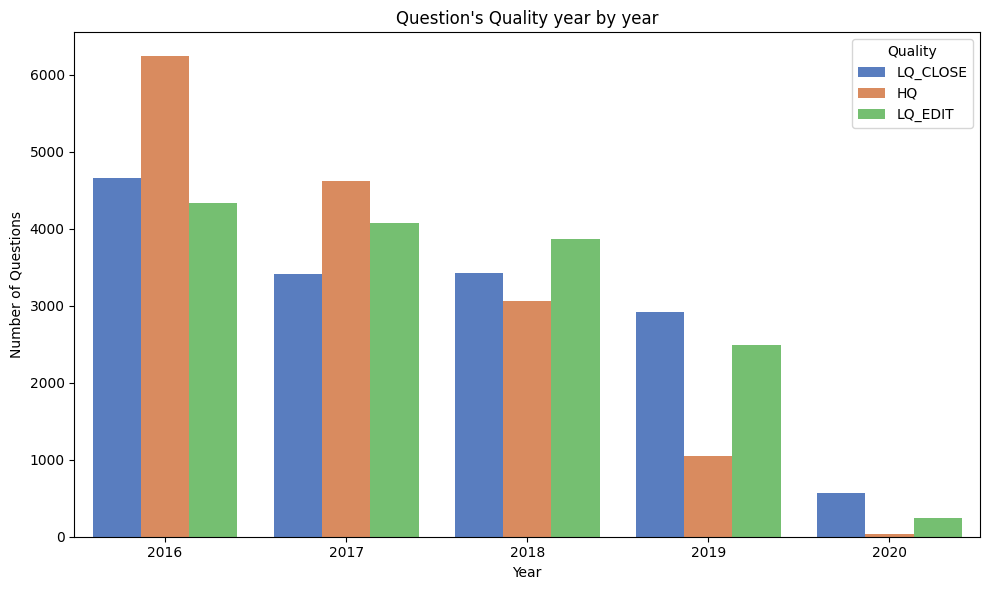

In [44]:
# Static seaborn countplot for Creation Year (renders inline)
plt.figure(figsize=(10,6))
sns.countplot(x='Creation_Year', hue='Y', data=train, palette='muted')
plt.title("Question's Quality year by year")
plt.xlabel('Year')
plt.ylabel('Number of Questions')
plt.xticks(rotation=0)
plt.legend(title='Quality')
plt.tight_layout()
plt.show()

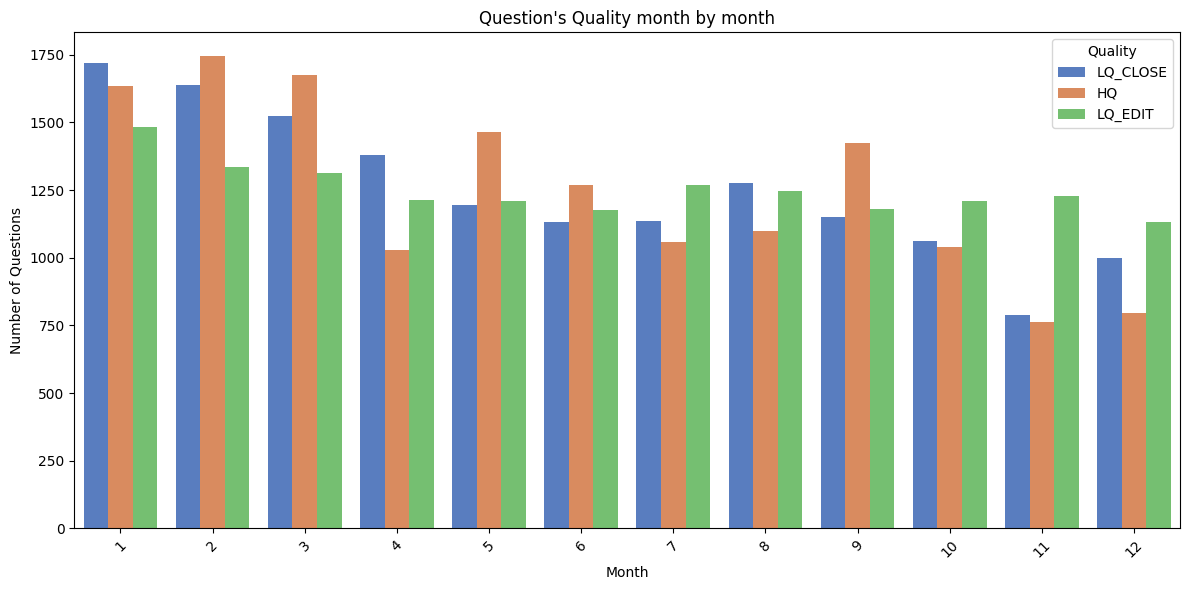

In [45]:
# Static seaborn countplot for Creation Month (renders inline)
plt.figure(figsize=(12,6))
sns.countplot(x='Creation_Month', hue='Y', data=train, palette='muted')
plt.title("Question's Quality month by month")
plt.xlabel('Month')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.legend(title='Quality')
plt.tight_layout()
plt.show()

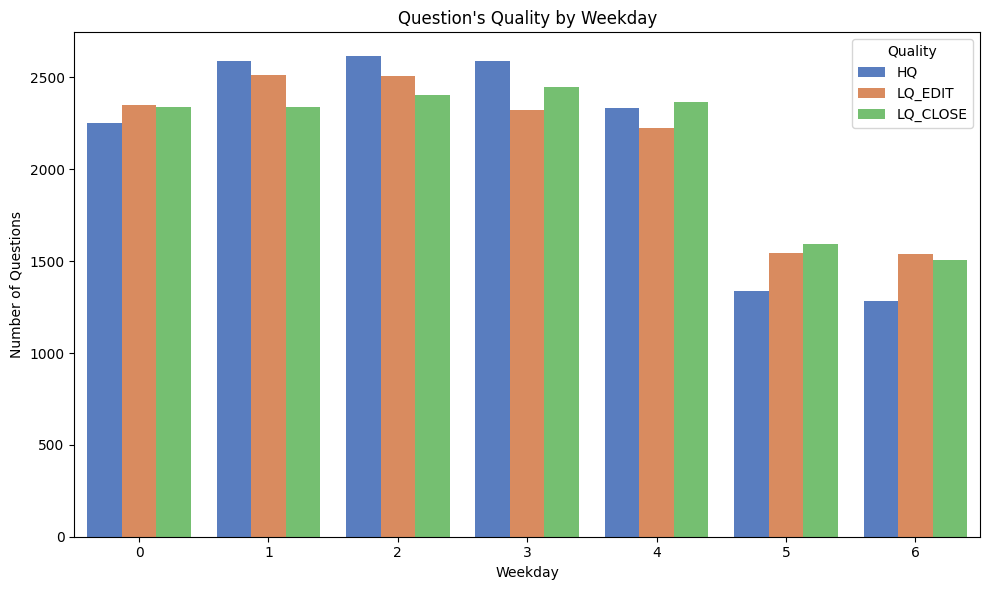

In [46]:
# Static seaborn countplot for Creation Weekday (renders inline)
plt.figure(figsize=(10,6))
sns.countplot(x='Creation_Weekday', hue='Y', data=train, palette='muted')
plt.title("Question's Quality by Weekday")
plt.xlabel('Weekday')
plt.ylabel('Number of Questions')
plt.xticks(rotation=0)
plt.legend(title='Quality')
plt.tight_layout()
plt.show()

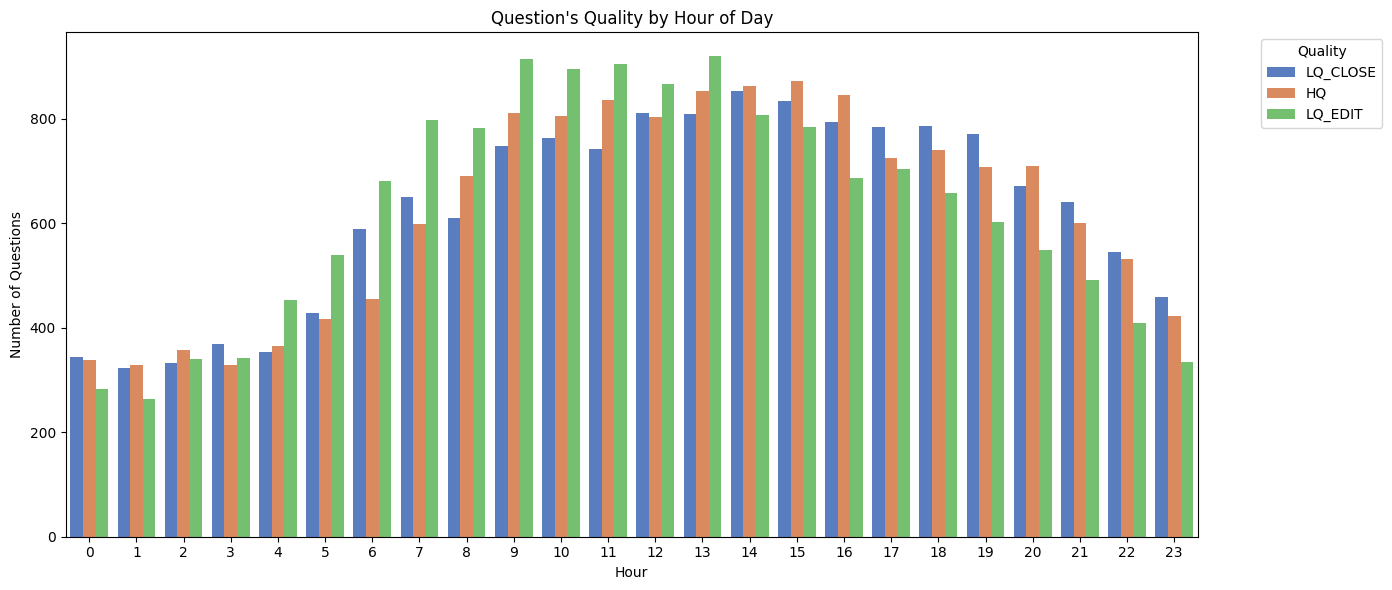

In [47]:
# Static seaborn countplot for Creation Hour (renders inline)
plt.figure(figsize=(14,6))
sns.countplot(x='Creation_Hour', hue='Y', data=train, palette='muted')
plt.title("Question's Quality by Hour of Day")
plt.xlabel('Hour')
plt.ylabel('Number of Questions')
plt.xticks(rotation=0)
plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

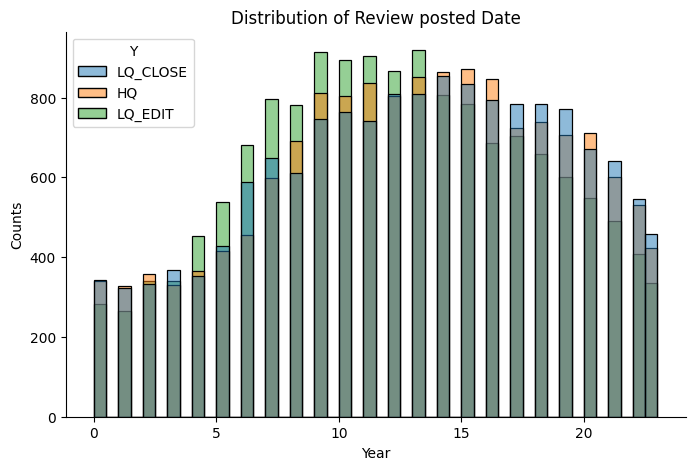

In [48]:
plt.figure(figsize=(8, 5))

sns.histplot(train, x='Creation_Hour', hue='Y')
plt.title('Distribution of Review posted Date')
plt.ylabel('Counts')
plt.xlabel('Year')
sns.despine()

#Saving the plot for Capstone Presentation and Report
plt.savefig('Distribution of Review posted Date by Class.jpeg', bbox_inches='tight')

plt.show()

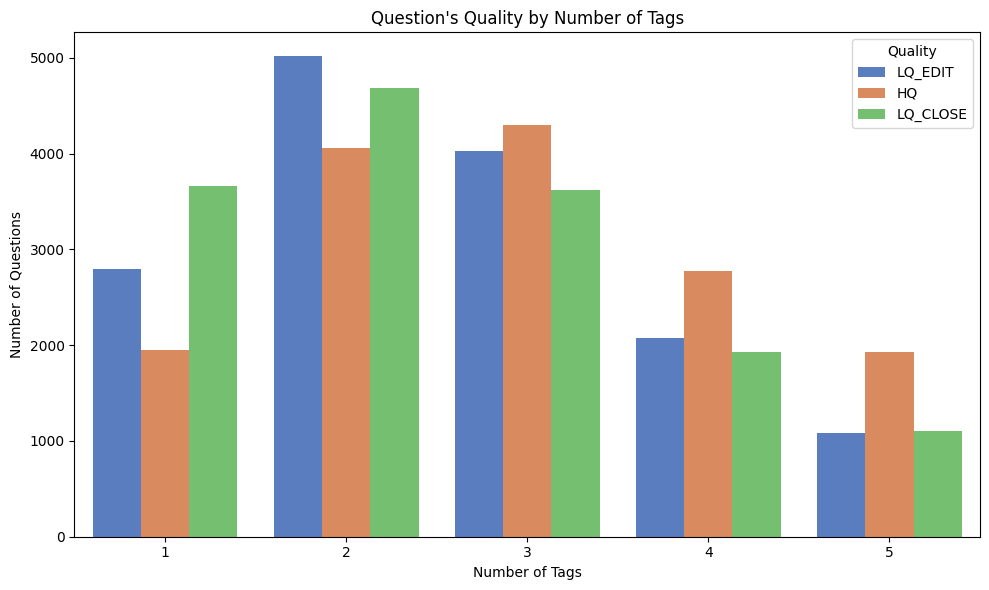

In [49]:
# Static seaborn countplot for Number of Tags (renders inline)
plt.figure(figsize=(10,6))
sns.countplot(x='Number_Of_Tags', hue='Y', data=train, palette='muted')
plt.title("Question's Quality by Number of Tags")
plt.xlabel('Number of Tags')
plt.ylabel('Number of Questions')
plt.xticks(rotation=0)
plt.legend(title='Quality')
plt.tight_layout()
plt.show()

In [50]:
train['Code_Available'].value_counts(normalize = True)

Code_Available
0    0.547637
1    0.452363
Name: proportion, dtype: float64

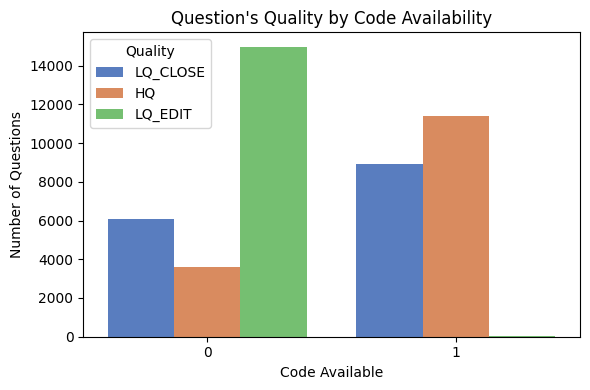

In [51]:
# Static seaborn countplot for Code Available (renders inline)
plt.figure(figsize=(6,4))
sns.countplot(x='Code_Available', hue='Y', data=train, palette='muted')
plt.title("Question's Quality by Code Availability")
plt.xlabel('Code Available')
plt.ylabel('Number of Questions')
plt.xticks(rotation=0)
plt.legend(title='Quality')
plt.tight_layout()
plt.show()

In [52]:
allTags = train['Tags'].apply(lambda x:x.replace('<','').replace('>',' ').lower())
allTags = list(allTags.values)
allTags = ''.join(allTags)
count = Counter(allTags.split())
len(count)

9336

In [53]:
count = pd.DataFrame(list(dict(count).items()),columns = ['Technology','Count'])
count.astype({'Count':'int64'})

count.sort_values('Count',axis =0,ascending = False,inplace = True)

In [54]:
count = count[count['Count']>=300]

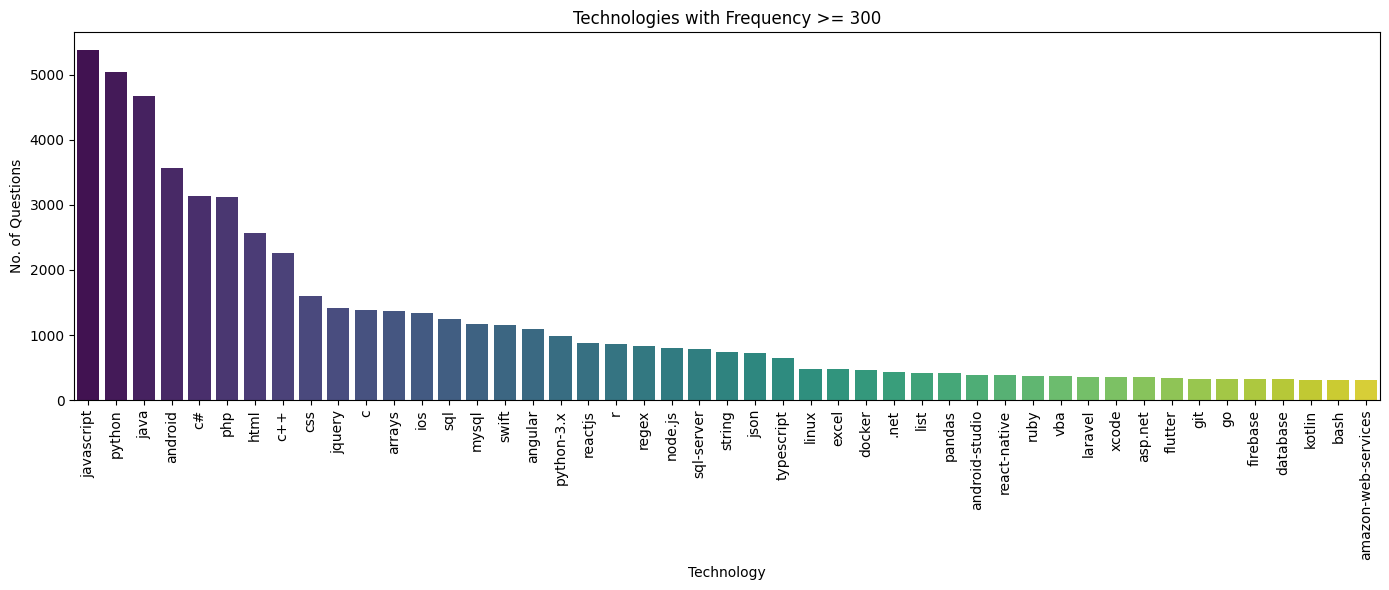

In [55]:
# Static bar plot for technologies with frequency >= 300
plt.figure(figsize=(14,6))
sns.barplot(data=count, x='Technology', y='Count', palette='viridis')
plt.title("Technologies with Frequency >= 300")
plt.xlabel('Technology')
plt.ylabel('No. of Questions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [56]:
tech = list(count['Technology'].values)
len(tech)

47

In [57]:
from sklearn.preprocessing import MultiLabelBinarizer

In [58]:
def tag_cleaner(val):
    splited = val.split('><')
    clean = []
    for tag in splited:
        tag =  tag.replace('<',' ')
        tag =  tag.replace('>',' ')
        clean.append(tag)
    return set(clean)

In [59]:
unique_tags = set()

for tag in train['Tags']:
    unique_tags = unique_tags|tag_cleaner(tag)

In [60]:
google_related      = []
prog_lang_related   = []
app_related         = []
ml_dl_related       = []
cs_am_related       = []
db_related          = []
web_dev_related     = []
electronics_related = []

prog_langs = ['swift','basic','c#','f#','c++','java','python','kotlin','camel','coffee','perl',
             'lisp','ruby','visual-studio','azure','assembly','go','haskell',',rust','.net','spyder',
             'jcl','sap','opengl','jenkins','apache','verilog','numpy']

web_keys = ['js','.j','net','docker','server','web','webpage','chrome','firefox','rest','api',
           'angular','react','node','facebook','twitter','amazon-ses','chromium','browser','ntp','svn',
           'xml','explorer','kivy','php']

app_android = ['android','apk','sdk','ipad','iphone','ios']

db_keys = ['db','sql','query','mongo','nosql','json','database','cloud','sql-server']
ml_dl_keys = ['tensorflow','machine_learning','deep_learning','scatter-plot','opencv','lda',
             'mlmodel','regression','principal-components','pca','pytorch','sklearn','face-recognition',
             ]
electronics_keys = ['esp8266','cpu','ram','core','tsu','gpu','arduino','raspberry']
cs_am_keys  = ['optimization','x509','class','array','sort','algorithm','code','runtime','header-files',
             'calculus','theory','geometry','polynomial']

c_unique_tags = unique_tags.copy()
c_unique_tags = list(c_unique_tags)
c_unique_tags = [tag.strip() for tag in c_unique_tags]

#google realted

for tag in c_unique_tags:
    if 'google'  in tag:
        google_related.append(tag)
c_unique_tags = [tag for tag in c_unique_tags if tag not in google_related]

#prog_lang realted

for tag in c_unique_tags:
    s_flag = False
    for plang in prog_langs:
        if s_flag is True:
            break;
        elif tag.find(plang) != -1:
            prog_lang_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in prog_lang_related]

#web_dev realted

for tag in c_unique_tags:
    s_flag = False
    for wk in web_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            web_dev_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in web_dev_related]

#phone/app_dev realted

for tag in c_unique_tags:
    s_flag = False
    for wk in app_android:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            app_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in app_related]

#database realted

for tag in c_unique_tags:
    s_flag = False
    for wk in db_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            db_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in db_related]

# machine learning and deep learning realted

for tag in c_unique_tags:
    s_flag = False
    for wk in ml_dl_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            ml_dl_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in ml_dl_related]


#electronics realted

for tag in c_unique_tags:
    s_flag = False
    for wk in electronics_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            electronics_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in electronics_related]

#cs_am realted

for tag in c_unique_tags:
    s_flag = False
    for wk in cs_am_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            cs_am_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in cs_am_related]

In [61]:
google_related_col = []    
prog_lang_related_col = []  
app_related_col = []        
ml_dl_related_col = []      
cs_am_related_col = []      
db_related_col = []         
web_dev_related_col = []    
electronics_related_col = []
other_related_col = []

In [62]:
for tag in train['Tags']:
    clean_tag = list(tag_cleaner(tag))
    google_related_score =0   
    prog_lang_related_score =0  
    app_related_score =0        
    ml_dl_related_score =0      
    cs_am_related_score =0      
    db_related_score =0         
    web_dev_related_score =0    
    electronics_related_score =0 
    other_related_score =0 

    for tg in clean_tag:
        zero_count = 0
        if tg in google_related:
            google_related_score = google_related_score +1
        else:
            zero_count = zero_count+1
        if tg in prog_lang_related:
            prog_lang_related_score = prog_lang_related_score+1
        else:
            zero_count = zero_count+1
        if tg in app_related:
            app_related_score=app_related_score+1
        else:
            zero_count = zero_count+1
        if tg in ml_dl_related:
            ml_dl_related_score = ml_dl_related_score + 1
        else:
            zero_count = zero_count+1
        if tg in cs_am_related:
            cs_am_related_score=cs_am_related_score+1
        else:
            zero_count = zero_count+1
        if tg in db_related:
            db_related_score=db_related_score+1
        else:
            zero_count = zero_count+1
        if tg in web_dev_related:
            web_dev_related_score=web_dev_related_score+1
        else:
            zero_count = zero_count+1
        if tg in electronics_related:
            electronics_related_score=electronics_related_score+1
        else:
            zero_count = zero_count+1
        if zero_count == 8:
            other_related_score = other_related_score + 1
    google_related_col.append(google_related_score)
    prog_lang_related_col.append(prog_lang_related_score) 
    app_related_col.append(app_related_score)       
    ml_dl_related_col.append(ml_dl_related_score)      
    cs_am_related_col.append(cs_am_related_score)  
    db_related_col.append(db_related_score)        
    web_dev_related_col.append(web_dev_related_score)  
    electronics_related_col.append(electronics_related_score) 
    other_related_col.append(other_related_score)

In [63]:
train['Google_Related_Tags'] = google_related_col
train['Programing_Language_Related_Tags'] = prog_lang_related_col
train['App/Phone_Related_ Tags'] = app_related_col
train['ML/DL_Related_Tags'] = ml_dl_related_col
train['CS/AM_Related_Tags'] = cs_am_related_col
train['DataBase/Storage_Related_Tags'] = db_related_col
train['WebApp/Dev_Related_Tags'] = web_dev_related_col
train['Electronics_Related_Tags'] = electronics_related_col
train['Unclassified_Related_Tags'] = other_related_col

In [64]:
unique_tags = set()

for tag in test['Tags']:
    unique_tags = unique_tags|tag_cleaner(tag)

In [65]:
google_related      = []
prog_lang_related   = []
app_related         = []
ml_dl_related       = []
cs_am_related       = []
db_related          = []
web_dev_related     = []
electronics_related = []

prog_langs = ['swift','basic','c#','f#','c++','java','python','kotlin','camel','coffee','perl',
             'lisp','ruby','visual-studio','azure','assembly','go','haskell',',rust','.net','spyder',
             'jcl','sap','opengl','jenkins','apache','verilog','numpy']

web_keys = ['js','.j','net','docker','server','web','webpage','chrome','firefox','rest','api',
           'angular','react','node','facebook','twitter','amazon-ses','chromium','browser','ntp','svn',
           'xml','explorer','kivy','php']

app_android = ['android','apk','sdk','ipad','iphone','ios']

db_keys = ['db','sql','query','mongo','nosql','json','database','cloud','sql-server']
ml_dl_keys = ['tensorflow','machine_learning','deep_learning','scatter-plot','opencv','lda',
             'mlmodel','regression','principal-components','pca','pytorch','sklearn','face-recognition',
             ]
electronics_keys = ['esp8266','cpu','ram','core','tsu','gpu','arduino','raspberry']
cs_am_keys  = ['optimization','x509','class','array','sort','algorithm','code','runtime','header-files',
             'calculus','theory','geometry','polynomial']

c_unique_tags = unique_tags.copy()
c_unique_tags = list(c_unique_tags)
c_unique_tags = [tag.strip() for tag in c_unique_tags]

#google realted

for tag in c_unique_tags:
    if 'google'  in tag:
        google_related.append(tag)
c_unique_tags = [tag for tag in c_unique_tags if tag not in google_related]

#prog_lang realted

for tag in c_unique_tags:
    s_flag = False
    for plang in prog_langs:
        if s_flag is True:
            break;
        elif tag.find(plang) != -1:
            prog_lang_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in prog_lang_related]

#web_dev realted

for tag in c_unique_tags:
    s_flag = False
    for wk in web_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            web_dev_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in web_dev_related]

#phone/app_dev realted

for tag in c_unique_tags:
    s_flag = False
    for wk in app_android:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            app_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in app_related]

#database realted

for tag in c_unique_tags:
    s_flag = False
    for wk in db_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            db_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in db_related]

# machine learning and deep learning realted

for tag in c_unique_tags:
    s_flag = False
    for wk in ml_dl_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            ml_dl_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in ml_dl_related]


#electronics realted

for tag in c_unique_tags:
    s_flag = False
    for wk in electronics_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            electronics_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in electronics_related]

#cs_am realted

for tag in c_unique_tags:
    s_flag = False
    for wk in cs_am_keys:
        if s_flag is True:
            break;
        elif tag.find(wk) != -1:
            cs_am_related.append(tag)
            s_flag=True
            continue
c_unique_tags = [tag for tag in c_unique_tags if tag not in cs_am_related]

In [66]:
google_related_col = []    
prog_lang_related_col = []  
app_related_col = []        
ml_dl_related_col = []      
cs_am_related_col = []      
db_related_col = []         
web_dev_related_col = []    
electronics_related_col = []
other_related_col = []

In [67]:
for tag in test['Tags']:
    clean_tag = list(tag_cleaner(tag))
    google_related_score =0   
    prog_lang_related_score =0  
    app_related_score =0        
    ml_dl_related_score =0      
    cs_am_related_score =0      
    db_related_score =0         
    web_dev_related_score =0    
    electronics_related_score =0 
    other_related_score =0 

    for tg in clean_tag:
        zero_count = 0
        if tg in google_related:
            google_related_score = google_related_score +1
        else:
            zero_count = zero_count+1
        if tg in prog_lang_related:
            prog_lang_related_score = prog_lang_related_score+1
        else:
            zero_count = zero_count+1
        if tg in app_related:
            app_related_score=app_related_score+1
        else:
            zero_count = zero_count+1
        if tg in ml_dl_related:
            ml_dl_related_score = ml_dl_related_score + 1
        else:
            zero_count = zero_count+1
        if tg in cs_am_related:
            cs_am_related_score=cs_am_related_score+1
        else:
            zero_count = zero_count+1
        if tg in db_related:
            db_related_score=db_related_score+1
        else:
            zero_count = zero_count+1
        if tg in web_dev_related:
            web_dev_related_score=web_dev_related_score+1
        else:
            zero_count = zero_count+1
        if tg in electronics_related:
            electronics_related_score=electronics_related_score+1
        else:
            zero_count = zero_count+1
        if zero_count == 8:
            other_related_score = other_related_score + 1
    google_related_col.append(google_related_score)
    prog_lang_related_col.append(prog_lang_related_score) 
    app_related_col.append(app_related_score)       
    ml_dl_related_col.append(ml_dl_related_score)      
    cs_am_related_col.append(cs_am_related_score)  
    db_related_col.append(db_related_score)        
    web_dev_related_col.append(web_dev_related_score)  
    electronics_related_col.append(electronics_related_score) 
    other_related_col.append(other_related_score)

In [68]:
test['Google_Related_Tags'] = google_related_col
test['Programing_Language_Related_Tags'] = prog_lang_related_col
test['App/Phone_Related_ Tags'] = app_related_col
test['ML/DL_Related_Tags'] = ml_dl_related_col
test['CS/AM_Related_Tags'] = cs_am_related_col
test['DataBase/Storage_Related_Tags'] = db_related_col
test['WebApp/Dev_Related_Tags'] = web_dev_related_col
test['Electronics_Related_Tags'] = electronics_related_col
test['Unclassified_Related_Tags'] = other_related_col

In [69]:
test['Tags'] = test['Tags'].apply(lambda x:x.replace('<','').replace('>',' '))
train['Tags'] = train['Tags'].apply(lambda x:x.replace('<','').replace('>',' '))

In [70]:
tags = train[['Tags']]
tags = pd.concat([tags[['Tags']], tags['Tags'].str.split(' ', expand = True)], axis = 1)
tags = tags.drop('Tags', axis = 1)
tags.head()

,0,1,2,3,4,5
0,java,repeat,,None,None,None
1,java,optional,,None,None,None
2,javascript,image,overlay,react-native,opacity,
3,swift,operators,whitespace,ternary-operator,optional,
4,android,material-design,floating-action-button,,None,None


In [71]:
from wordcloud import WordCloud, STOPWORDS

plt.rcParams['figure.figsize'] = (6, 6)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(tags[0]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular technologies',fontsize = 20)
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

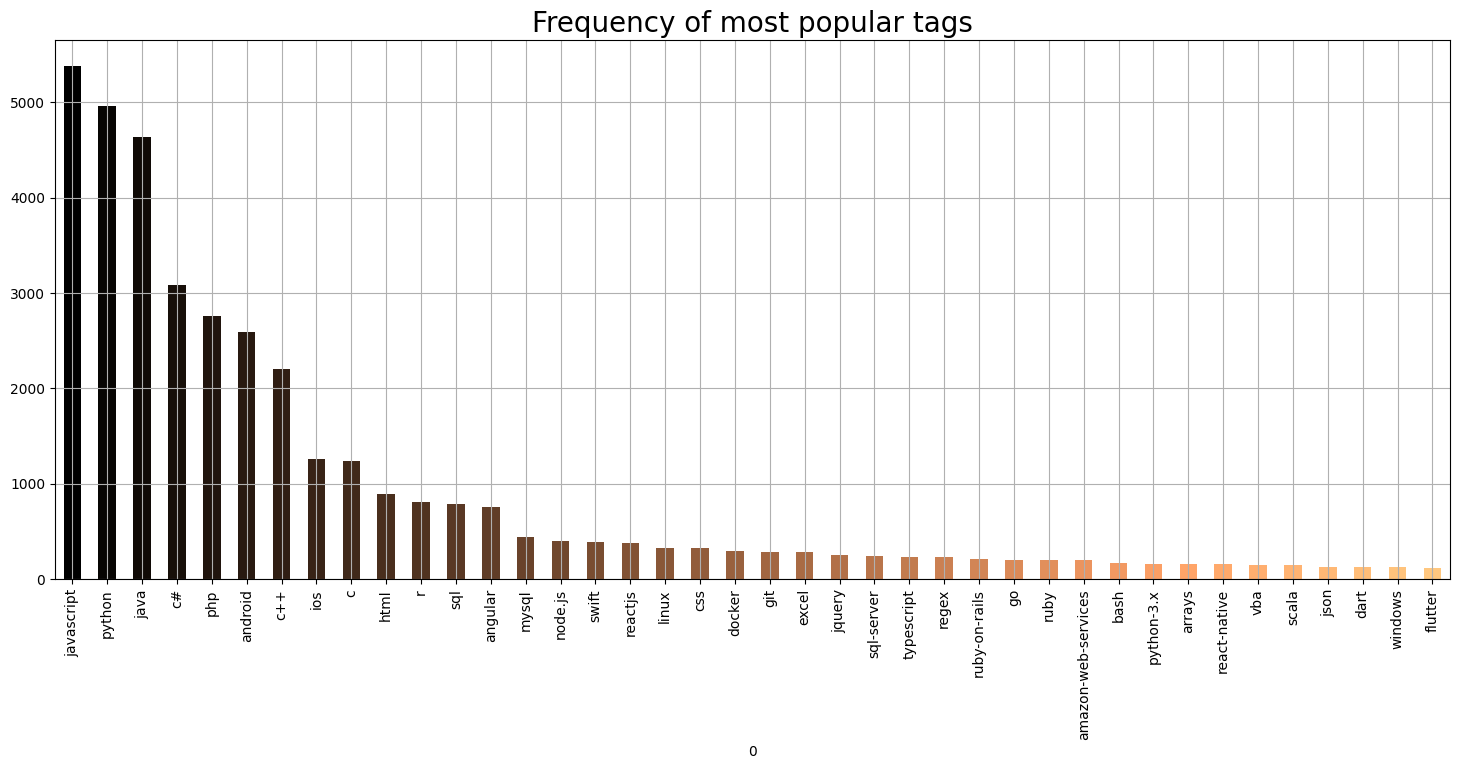

In [72]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
tags[0].value_counts().head(40).plot.bar(color = color)
plt.title('Frequency of most popular tags', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [73]:
train['Body'][10]

'<p>I am new to Ubuntu (Linux tbh). I encountered problem with starting MongoDB service. I want to created web app using Ruby on Rails and MongoDB but mongo seems to fail to start.</p>\n\n<p>I followed this <a href="https://docs.mongodb.org/v3.0/tutorial/install-mongodb-on-ubuntu/">MongoDB installation on Ubuntu</a> all of installation went without problems until I got to <code>sudo service mongod start</code> </p>\n\n<p><strong>mongod.log</strong></p>\n\n<pre><code>2016-01-01T10:58:15.545+0000 I CONTROL  ***** SERVER RESTARTED *****\n2016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] MongoDB starting : pid=3868 port=27017 dbpath=/var/lib/mongodb 64-bit host=damian-CX61-0NC-CX61-0ND-CX61-0NF-CX61-0NE\n2016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] db version v3.0.8\n2016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] git version: 83d8cc25e00e42856924d84e220fbe4a839e605d\n2016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] build info: Linux ip-10-187-89-126 3.13.0-

In [74]:
test['Body'] = test['Body'].apply(lambda x:bsp(x,'html.parser').text.replace('\\','').replace('\n','').replace('\t','').replace('\r',''))

In [75]:
train['Body'] = train['Body'].apply(lambda x:bsp(x,'html.parser').text.replace('\\','').replace('\n','').replace('\t','').replace('\r',''))

In [76]:
train['Body'][10]

'I am new to Ubuntu (Linux tbh). I encountered problem with starting MongoDB service. I want to created web app using Ruby on Rails and MongoDB but mongo seems to fail to start.I followed this MongoDB installation on Ubuntu all of installation went without problems until I got to sudo service mongod start mongod.log2016-01-01T10:58:15.545+0000 I CONTROL  ***** SERVER RESTARTED *****2016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] MongoDB starting : pid=3868 port=27017 dbpath=/var/lib/mongodb 64-bit host=damian-CX61-0NC-CX61-0ND-CX61-0NF-CX61-0NE2016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] db version v3.0.82016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] git version: 83d8cc25e00e42856924d84e220fbe4a839e605d2016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] build info: Linux ip-10-187-89-126 3.13.0-24-generic #46-Ubuntu SMP Thu Apr 10 19:11:08 UTC 2014 x86_64 BOOST_LIB_VERSION=1_492016-01-01T10:58:15.548+0000 I CONTROL  [initandlisten] allocator: tcmalloc201

In [77]:
test['Title'] = test['Title'].apply(lambda x:bsp(x,'html.parser').text.replace('\\','').replace('\n','').replace('\t','').replace('\r',''))

In [78]:
train['Title'] = train['Title'].apply(lambda x:bsp(x,'html.parser').text.replace('\\','').replace('\n','').replace('\t','').replace('\r',''))

In [79]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text
train['Body'] = train['Body'].apply(clean_text)
test['Body'] = test['Body'].apply(clean_text)

In [80]:
train['Title'] = train['Title'].apply(clean_text)
test['Title'] = test['Title'].apply(clean_text)

In [81]:
train['Body'][10]

'i am new to ubuntu (linux tbh) i encountered problem with starting mongodb service i want to created web app using ruby on rails and mongodb but mongo seems to fail to starti followed this mongodb installation on ubuntu all of installation went without problems until i got to sudo service mongod start mongodlogt i control   server restarted t i control  initandlisten mongodb starting  pid port dbpathvarlibmongodb bit hostdamiancxnccxndcxnfcxnet i control  initandlisten db version vt i control  initandlisten git version dcceedefbeaedt i control  initandlisten build info linux ip generic ubuntu smp thu apr   utc  x boostlibversiont i control  initandlisten allocator tcmalloct i control  initandlisten options  config etcmongodconf net  bindip  port   storage  dbpath varlibmongodb journal  enabled true   systemlog  destination file logappend true path varlogmongodbmongodlog  t e network  initandlisten failed to unlink socket file tmpmongodbsock errno operation not permittedt i         ini

In [82]:
def word_cloud(values):
    wordcloud = WordCloud(width = 500, height = 300, 
                background_color ='white', 
                min_font_size = 10).generate(values) 
    
    plt.figure(figsize=(19,9))

    plt.axis('off')
    plt.title("Without Stop Words")
    plt.imshow(wordcloud)
    plt.show()

In [83]:
Java = train[train['Tags'].str.contains('java')]['Body'].values

Java = ' '.join(list(Java))
word_cloud(Java)

NameError: name 'WordCloud' is not defined

In [84]:
JavaScript = train[train['Tags'].str.contains('javascript')]['Body'].values

JavaScript = ' '.join(list(JavaScript))
word_cloud(JavaScript)

NameError: name 'WordCloud' is not defined

In [85]:
Python = train[train['Tags'].str.contains('python')]['Body'].values

Python = ' '.join(list(Python))
word_cloud(Python)

NameError: name 'WordCloud' is not defined

In [86]:
drop_col = ['Tags']

train.drop(columns=drop_col, inplace=True)
test.drop(columns=drop_col, inplace=True)

In [87]:
data = np.triu(train.corr())

plt.figure(figsize=(22, 18))
sns.heatmap(round(train.corr(),2), 
            annot = True,
            cmap = 'coolwarm', 
            vmin = -1, 
            vmax = 1,
            mask = data)

ValueError: could not convert string to float: 'java repeat task every random seconds'

In [ ]:
# import sys
# print('sys.executable:', sys.executable)

# try:
#     import nbformat
#     print('nbformat:', nbformat.__version__)
# except Exception as e:
#     print('nbformat import error:', e)

# import plotly.io as pio
# print('plotly renderers:', pio.renderers)

# # Also list sys.path first entries for clarity
# import json
# print('sys.path[0:5]:', json.dumps(sys.path[0:5]))
